# Stable diffusion with Diffusers

This is a notebook that demonstrates how to use the [Diffusers package](https://huggingface.co/docs/diffusers/index) from Huggingface to run stable diffusion. [Huggingface](https://huggingface.co) is a community-driven  platform that provides a comprehensive suite of open-source libraries and tools for machine learning. Think of it as a kind of "github for machine learning". The diffusers package provides a simple API and a number of pretrained models that allow to easily run and experiment with diffusion models. 

**NOTE** this notebook should work on other platform, but it has been only tested on Mac (M1). 

## Installation
To use this notebook you will create a new conda environment:
```
conda create -n diffusers python=3.10
```
Then activate the environment and install the requirements with
```
conda activate diffusers
conda install -c conda-forge jupyter
conda install pytorch torchvision -c pytorch
conda install -c conda-forge pycairo opencv scikit-image matplotlib
pip install --upgrade diffusers
pip install transformers
pip install accelerate
```


## Running stable diffusion
To run stable diffusion you will need to distinguish wether you are running this on a Mac M1/M2 or on Linux/Windows with a Nvidia GPU. 
On a M1/M2 Mac, diffusion will need a "warmup" phase to work properly (see [this link](https://huggingface.co/docs/diffusers/optimization/mps))

In [1]:
import platform
if platform.processor() == 'arm':
    print("Detected Mac M1/M2")
    device = 'mps'
else:
    device = 'cuda'

Detected Mac M1/M2


Now this will load the pretrained model and download it the first time the cell is run (which might take a while).

In [2]:
from diffusers import StableDiffusionPipeline
generator = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
generator = generator.to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/colormotor/opt/miniconda3/envs/diffusers/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
if device=='mps':
    # Recommended if your computer has < 64 GB of RAM
    generator.enable_attention_slicing()

prompt = "A cubist painting of the Star Treck character Spock, high quality, trending on artstation"

if device=='mps':
    # First-time "warmup" pass for M1/M2 macs
    _ = generator(prompt, num_inference_steps=1)


  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generate the image (note increasing `num_inference_steps` will improve quality but be slower)

In [4]:

image = generator(prompt, num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

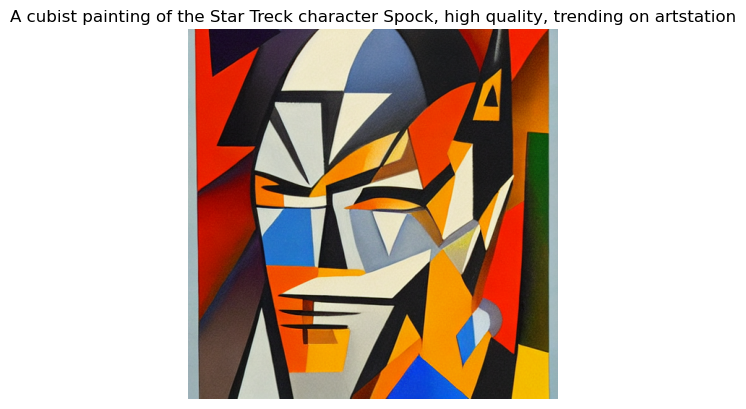

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()

## Conditioning stable diffusion with ControlNet

[ControlNet](https://stablediffusionweb.com/ControlNet) is a very recent and quite amazing advancement in image generation using stable diffusion. It allows conditioning the stable diffusion generation pipeline on an image input (similarly to pix2pix).

If you are running a Mac, you will need to update torch to the "nightly" version with
```
conda update pytorch torchvision -c pytorch-nightly
```
(see here: https://github.com/huggingface/diffusers/issues/2521)

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

Let's use skimage to create edges. Note that here we use PIL to display the image  

uint8 255


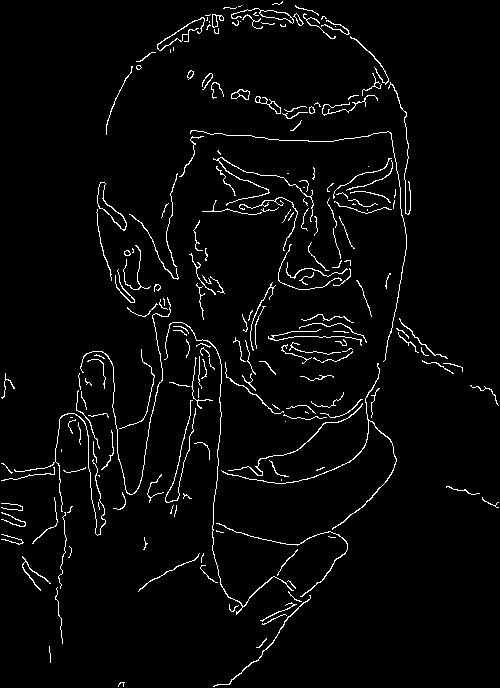

In [15]:
import numpy as np
from skimage import io, feature
import PIL.Image as Image
import cv2


def apply_canny_skimage(img, sigma=1.5):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    print(edges.dtype, np.max(edges))
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

img = io.imread("images/spock.jpg")

edges =  apply_canny_skimage(img)
edges_image = Image.fromarray(edges)
edges_image


Setup the ControlNet model. Somehow converting to device takes ages on Mac.

In [16]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
import PIL.Image as Image

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16)
    
generator = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    controlnet=controlnet, 
    safety_checker=None)
print("converting to device")
generator = generator.to(device)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/colormotor/opt/miniconda3/envs/diffusers/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


converting to device


In [17]:
prompt = "A sculpture made of clay on a white background"

if device=='mps':
    generator.enable_attention_slicing()
    _ = generator(prompt, image=edges_image, num_inference_steps=1)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

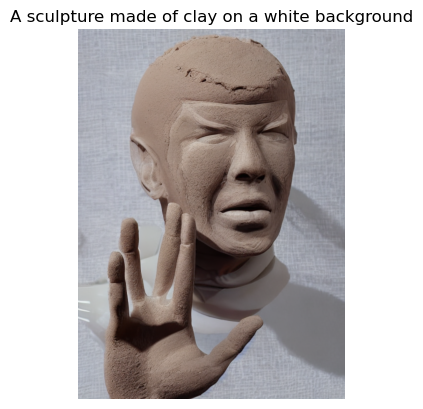

In [18]:
import numpy as np
import matplotlib.pyplot as plt

image = generator(
    prompt,
    image=edges_image,
    num_inference_steps=30,
).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()